# Assessment of Renewable Energy Potentials based on Land Availability

The analysis of land availability for renewable energy potentials is divided into three stages. In this script, we will focus on the third stage: **Capacity and generation analysis**

-Goal: conduct analysis of power generation estimation, capacity, and capacity factor under three methods:
1. Capacity profile assumptions
2. Real PV/turbine selection
3. Estimated hourly generation  

-Steps: Calculate the installed capacity and estimate the power generation for comparison:
1. Import data (data from stage 2, and data for three methods)
2. Setup assumptions based on data from stage 2 (whole country and regional division)
3. Method 1: Calculate the potentials capacity & annual generation via capacity profile assumptions<br>
(a) whole country<br>
(b) Regional division (under development) <br>
4. Method 2: Calculate the potentials capacity & annual generation via real PV/turbine selection<br>
(a) whole country<br>
(b) Regional division (under development) <br>
5. Method 3: Calculate the potentials capacity & annual generation via average hourly generation from 4 different cities<br>
(a) whole country<br>
(b) Regional division (under development) <br>

6. Comparison of different methods
**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

In [25]:
# import necessary library
# Set-up to have matplotlib use its support for notebook inline plots
%matplotlib inline
import matplotlib.pyplot as plt # Convention for import of the pyplot interface
from matplotlib.patches import Patch # for legend editing
from matplotlib.colors import BoundaryNorm
from matplotlib import rcParams, cycler
import os # operating system interfaces 
import datetime # time data sorting
import numpy as np # array and data sorting package
import pandas as pd # dataframe sorting package
import seaborn as sns # Use seaborn style defaults and set the default figure size
import geopandas # geospatial data processing package
import shapely.speedups # geospatial data speedup package
import xarray as xr # deal with time series data (grib and NetCDF files)

## 1. Import data (data from stage 2, and data for three methods)

### a. Import the **land area** from the **result of stage 2**

In [2]:
# Import final available land (from stgae 2)
land_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_al_ts_sl.csv')

# Import result data of wind resources from stge 2
sc3_wind_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_wind.csv')

# Import result data of solar resources from stge 2
sc3_solar_gdf = pd.read_csv('Vietnam/02_output_stage2/02_vn_scenario3_solar.csv')

### b. Import data for three methods

In [4]:
# Wind Speed and Solar Radiation data for Method 2
# import data (ERA5, Latitude x Longtitude: 0.25° x 0.25°) (01/01/2020-31/12/2020)
ds = xr.open_dataset('Vietnam/00_data_time_series/ERA5/hourly_data_2020_era5.nc')
# convert time series data (ds) to dataframe
df = ds.to_dataframe()

# drop all index
df.reset_index(drop=False, inplace=True)

# reset time column into date time and select it as new index
df["time"] = pd.to_datetime(df["time"])
df.set_index('time')

# add year, month and day name
df['year'] = pd.DatetimeIndex(df['time']).year
df['month'] = pd.DatetimeIndex(df['time']).month
df['day'] = pd.DatetimeIndex(df['time']).day
df['hour'] = pd.DatetimeIndex(df['time']).hour
df.head()

,latitude,longitude,time,u100,v100,fdir,year,month,day,hour
0,24.0,101.0,2020-01-01 00:00:00,0.498847,0.980772,0.000,2020,1,1,0
1,24.0,101.0,2020-01-01 01:00:00,0.199315,0.907117,24523.625,2020,1,1,1
2,24.0,101.0,2020-01-01 02:00:00,0.110454,0.916045,97986.875,2020,1,1,2
3,24.0,101.0,2020-01-01 03:00:00,0.580720,0.776548,263574.875,2020,1,1,3
4,24.0,101.0,2020-01-01 04:00:00,0.564745,0.695081,266317.625,2020,1,1,4


In [5]:
# wind time series data
# wind speed = (u**2 + v**2)**(1/2)
df['wind_speed_at_height_100m[m/s]'] = ((df['u100'])**2 + (df['v100'])**2)**(1/2)

# solar time series data
# from j/m2 to kWh/m2
# 1kwh = 3.6 x10**6 j
df['total_sky_direct_solar_radiation_at_surface[Wh/m2]'] = df['fdir']/(3.6*(10**3))

#rename the titles
# create a dictionary and renew the titles

dict = {'u100': 'u-component_of_wind_speed_at_height_100m[m/s]',
        'v100': 'v-component_of_wind_speed_at_height_100m[m/s]',
        'fdir': 'total_sky_direct_solar_radiation_at_surface[J/m2]',
       }

# call rename () method
df.rename(columns=dict,
          inplace=True)

df = df[['latitude', 'longitude', 'time', 'year', 'month', 'day', 'hour',
         'u-component_of_wind_speed_at_height_100m[m/s]', 
         'v-component_of_wind_speed_at_height_100m[m/s]', 
         'wind_speed_at_height_100m[m/s]',
         'total_sky_direct_solar_radiation_at_surface[J/m2]', 
         'total_sky_direct_solar_radiation_at_surface[Wh/m2]']]
df.head()

,latitude,longitude,time,year,month,day,hour,u-component_of_wind_speed_at_height_100m[m/s],v-component_of_wind_speed_at_height_100m[m/s],wind_speed_at_height_100m[m/s],total_sky_direct_solar_radiation_at_surface[J/m2],total_sky_direct_solar_radiation_at_surface[Wh/m2]
0,24.0,101.0,2020-01-01 00:00:00,2020,1,1,0,0.498847,0.980772,1.100346,0.000,0.000000
1,24.0,101.0,2020-01-01 01:00:00,2020,1,1,1,0.199315,0.907117,0.928756,24523.625,6.812118
2,24.0,101.0,2020-01-01 02:00:00,2020,1,1,2,0.110454,0.916045,0.922680,97986.875,27.218576
3,24.0,101.0,2020-01-01 03:00:00,2020,1,1,3,0.580720,0.776548,0.969671,263574.875,73.215240
4,24.0,101.0,2020-01-01 04:00:00,2020,1,1,4,0.564745,0.695081,0.895586,266317.625,73.977119


In [721]:
# Wind Speed and Solar Radiation data for Method 3
# Select the csv files from time-series folder
files = os.listdir('Vietnam/00_data_time_series/RenewablesNinja')    
files = list(filter(lambda f: f.endswith('.csv'), files))
files

['pv_250w_DaNang_16.0680_108.2120.csv',
 'pv_250w_Hanoi_21.0294_105.8544.csv',
 'pv_250w_HoChiMinh_10.7758_106.7018.csv',
 'pv_250w_Vinh_18.6692_105.6882.csv',
 'pv_600w_DaNang_16.0680_108.2120.csv',
 'pv_600w_Hanoi_21.0294_105.8544.csv',
 'pv_600w_HoChiMinh_10.7758_106.7018.csv',
 'pv_600w_Vinh_18.6692_105.6882.csv',
 'wind_100m_E126_75MW_DaNang_16.0680_108.2120.csv',
 'wind_100m_E126_75MW_Hanoi_21.0294_105.8544.csv',
 'wind_100m_E126_75MW_HoChiMinh_10.7758_106.7018.csv',
 'wind_100m_E126_75MW_Vinh_18.6692_105.6882.csv',
 'wind_100m_V90_2MW_DaNang_16.0680_108.2120.csv',
 'wind_100m_V90_2MW_Hanoi_21.0294_105.8544.csv',
 'wind_100m_V90_2MW_HoChiMinh_10.7758_106.7018.csv',
 'wind_100m_V90_2MW_Vinh_18.6692_105.6882.csv']

In [722]:
# change directory to the generation data folder
#os.chdir('Users/yu-chi.chang/GIS_Land_VN/Vietnam/00_data_time_series/RenewablesNinja')
os.chdir('Vietnam/00_data_time_series/RenewablesNinja')
os.getcwd()

'C:\\Users\\yu-chi.chang\\GIS_Land_VN\\Vietnam\\00_data_time_series\\RenewablesNinja'

In [726]:
# corresponding cities and data
city_df = pd.read_excel('Cities.xlsx')
city = city_df['city']
city_lat = city_df['Lat']
city_long = city_df['Long']
city_types = city_df['Types']
city_cap = city_df['Capacity_PV_W_Wind_MW']

# Import first city to initiate the dataframe
# solar pv generation
pv_fileOne_df = pd.read_csv(files[0])
pv_fileOne_df['city']=city[0]
pv_fileOne_df['latitude']=city_lat[0]
pv_fileOne_df['longtitude']=city_long[0]
pv_fileOne_df['type']=city_types[0]
pv_fileOne_df['capacity']=city_cap[0]
pv_fileOne_df = pv_fileOne_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]

# wind turbine generation
wt_fileOne_df = pd.read_csv(files[8])
wt_fileOne_df['city']=city[8]
wt_fileOne_df['latitude']=city_lat[8]
wt_fileOne_df['longtitude']=city_long[8]
wt_fileOne_df['type']=city_types[8]
wt_fileOne_df['capacity']=city_cap[8]
wt_fileOne_df = wt_fileOne_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]

# put rest of three cities into the dataframe
# solar pv generation
for i in range(1, 8):
    pv_files_df = pd.read_csv(files[i])
    pv_files_df['city']=city[i]
    pv_files_df['latitude']=city_lat[i]
    pv_files_df['longtitude']=city_long[i]
    pv_files_df['type']=city_types[i]
    pv_files_df['capacity']=city_cap[i]
    pv_files_df = pv_files_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]
    pv_fileOne_df = pv_fileOne_df.append(pv_files_df)

# wind turbine generation
for i in range(9, 16):
    wt_files_df = pd.read_csv(files[i])
    wt_files_df['city']=city[i]
    wt_files_df['latitude']=city_lat[i]
    wt_files_df['longtitude']=city_long[i]
    wt_files_df['type']=city_types[i]
    wt_files_df['capacity']=city_cap[i]
    wt_files_df = wt_files_df[['local_time', 'electricity', 'city', 'latitude', 'longtitude', 'type', 'capacity']]
    wt_fileOne_df = wt_fileOne_df.append(wt_files_df)
    
pv_fileOne_df.head()

,local_time,electricity,city,latitude,longtitude,type,capacity
0,01/01/2019 07:00,0.013,DaNang,16.068,108.212,PHOT,250.0
1,01/01/2019 08:00,0.032,DaNang,16.068,108.212,PHOT,250.0
2,01/01/2019 09:00,0.049,DaNang,16.068,108.212,PHOT,250.0
3,01/01/2019 10:00,0.064,DaNang,16.068,108.212,PHOT,250.0
4,01/01/2019 11:00,0.074,DaNang,16.068,108.212,PHOT,250.0


In [727]:
# change back to the original directory
os.chdir('../../..')
os.getcwd()

'C:\\Users\\yu-chi.chang\\GIS_Land_VN'

## 2. Setup assumptions based on data from stage 2 (whole country and regional division)

### a. Calculate the total land area

In [6]:
name = 'Vietnam'
land_sum = land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Total areas in square kilometers
print('Total area of scenario 3 in', name, ':', land_sum,'km^2')

Total area of scenario 3 in Vietnam : 1611.7824709170907 km^2


### b. Divide the land area into different regions
The regions area defined based on https://en.wikipedia.org/wiki/List_of_regions_of_Vietnam

In [8]:
# separate into regions: Northeast, Northwest, Red River Delta, North Central Coast, South Central Coast, Central Highlands, Southeast, Mekong River Delta 
# Northwest
nw_list = ['Dien Bien','Hoa Binh', 'Lai Chau', 'Lao Cai', 'Son La', 'Yen Bai']
nw_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_list))]
# Northeast
ne_list = ['Bac Giang','Bac Kann', 'Cao Bangu', 'Ha Giang', 'Lang Son', 'Phu Tho', 'Quang Ninh', 'Thai Nguyen', 'Tuyen Quang']
ne_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ne_list))]
# Red River Delta
rrd_list = ['Bac Ninh', 'Ha Nam', 'Ha Noi', 'Hai Duong', 'Hai Phong', 'Hung Yen', 'Nam Dinh', 'Ninh Binh', 'Thai Binh', 'Vinh Phuc']
rrd_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(nw_land_df))]
# North Central Coast
ncc_list = ['Ha Tinh', 'Nghe An', 'Quang Binh', 'Quang Tri', 'Thanh Hoa', 'Thua Thien Hue']
ncc_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ncc_list))]
# South Central Coast
scc_list = ['Binh Dinh', 'Binh Thuan', 'Da Nang', 'Khanh Hoa', 'Ninh Thuan', 'Phu Yen', 'Quang Nam', 'Quang Ngai']
scc_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(scc_list))]
# Central Highlands
ch_list = ['Dak Lak', 'Dak Nong', 'Gia Lai', 'Kon Tum', 'Lam Dong']
ch_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(ch_list))]
# Southeast
se_list = ['Ba Ria Vung Tau', 'Binh Duong', 'Binh Phuoc', 'Dong Nai', 'Saigon', 'Tay Ninh']
se_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(se_list))]
# Mekong River Delta
mrd_list = ['An Giang', 'Ben Tre', 'Bac Lieu', 'Ca Mau', 'Can Tho City', 'Dong Thap', 'Hau Giang',
             'Kien Giang', 'Long An', 'Soc Trang', 'Tien Giang', 'Tra Vinh', 'Vinh Long']
mrd_land_gdf = land_gdf[land_gdf['ADM1_EN'].str.contains('|'.join(mrd_list))]

### c. Calculate the land area of different regions

In [11]:
region_name = ['Northwest', 'Northeast', 'Red River Delta', 'orth Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']

# Northwest
nw_land_sum = nw_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Northeast
ne_land_sum = ne_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Red River Delta
rrd_land_sum= rrd_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# North Central Coast
ncc_land_sum = ncc_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# South Central Coast
scc_land_sum = scc_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Central Highlands
ch_land_sum = ch_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Southeast
se_land_sum = se_land_gdf['area_km2'].sum(axis = 0, skipna = True)
# Mekong River Delta
mrd_land_sum = mrd_land_gdf['area_km2'].sum(axis = 0, skipna = True)

# Total areas in square kilometers
print('Total available land of scenario 3 in \n',
      region_name[0], ':', nw_land_sum,'km^2 \n',
      region_name[1], ':', ne_land_sum,'km^2 \n',
      region_name[2], ':', rrd_land_sum,'km^2 \n',
      region_name[3], ':', ncc_land_sum,'km^2 \n',
      region_name[4], ':', scc_land_sum,'km^2 \n',
      region_name[5], ':', ch_land_sum,'km^2 \n',
      region_name[6], ':', se_land_sum,'km^2 \n',
      region_name[7], ':', mrd_land_sum,'km^2')

Total available land of scenario 3 in 
 Northwest : 8.202899173828696 km^2 
 Northeast : 87.17808683301098 km^2 
 Red River Delta : 0.0 km^2 
 orth Central Coast : 27.929101440956394 km^2 
 South Central Coast : 0.0487352973484093 km^2 
 Central Highlands : 0.0 km^2 
 Southeast : 24.939239965118528 km^2 
 Mekong River Delta : 1170.3630174142522 km^2


### d. Plot Graph of Available Land in Scenario3 of Different Regions

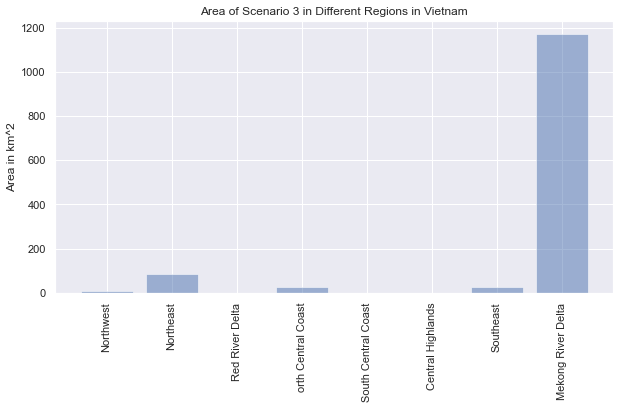

In [12]:
area_name_arr = ['Northwest', 'Northeast', 'Red River Delta', 'orth Central Coast', 'South Central Coast', 'Central Highlands', 'Southeast', 'Mekong River Delta']
y_pos = np.arange(len(area_name_arr))
area_sum_arr = [nw_land_sum, ne_land_sum, rrd_land_sum, ncc_land_sum, scc_land_sum, ch_land_sum, se_land_sum, mrd_land_sum]
sns.set(rc={'figure.figsize':(10,5)})
plt.bar(y_pos, area_sum_arr, align='center', alpha=0.5)
plt.xticks(y_pos, area_name_arr, rotation='vertical')
plt.ylabel('Area in km^2')
plt.title('Area of Scenario 3 in Different Regions in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_area_scenario3_regions.tiff',bbox_inches='tight', dpi=300)
plt.show()

## 3. Method 1: Calculate the potentials capacity & annual generation via capacity profile assumptions
(a) whole country<br>
(b) Regional division (under development) <br>

**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. HC/LC profile assumptions

In [827]:
# shares of utility solar pv and onshore wind farm
pv_sh = 0.5
wt_sh = 0.5

# wind
# HC/LC profile
# capactiy of one wind turbine according to High Capacity (HC) Profile (7.5 MW)
wt_hc_c = 7.5
# capactiy of one wind turbine according to Low Capacity (LC) Profile (1 MW)
wt_lc_c = 1
# rotor diameter (km)
dia = 0.1
# distance between wind turbine: L*W = (5*rotor diameter)*(5*rotor diameter) (km2)
wt_d = 4*dia*4*dia

# solar
# HC/LC profile
# capactiy of one PV panel according to High Capacity (HC) Profile (650 Wp) / Power Density (300 W/km2)
pv_hc_c = 650
pv_hc_pd = 300
# capactiy of one PV panel according to Low Capacity (LC) Profile (250 Wp)/ Power Density (50 W/km2)
pv_lc_c = 250
pv_lc_pd = 50
# efficiency factor of the PV modules: 20 (%)
pv_ef = 0.2

### b. Calculation of capacity and generation

- Wind (Onshore): capacity factor (according to wind class IEC1-IEC3)

In [822]:
# potential capacity of HC/LC profile (GW) = (50% of land area * capacity of one wind turbine) / (distance between wind turbines * 1000)
wt_pc_lc = land_sum*wt_sh*wt_lc_c/wt_d/1000
wt_pc_hc = land_sum*wt_sh*wt_hc_c/wt_d/1000

# average capacity factor of a region according to wind class IEC1-IEC3
wt_cf1_sum = sc3_wind_gdf['capacity_factor_iec1'].mean(axis = 0, skipna = True)
wt_cf2_sum = sc3_wind_gdf['capacity_factor_iec2'].mean(axis = 0, skipna = True)
wt_cf3_sum = sc3_wind_gdf['capacity_factor_iec3'].mean(axis = 0, skipna = True)

# oneshore windfarm estimated annual generation of HC/LC profile (TWh) = (potential capacity * capactiy factor * 8760 hours) / 1000
wt_ag_cf1_lc = wt_pc_lc*wt_cf1_sum*8760/1000
wt_ag_cf2_lc = wt_pc_lc*wt_cf2_sum*8760/1000
wt_ag_cf3_lc = wt_pc_lc*wt_cf3_sum*8760/1000
wt_ag_cf1_hc = wt_pc_hc*wt_cf1_sum*8760/1000
wt_ag_cf2_hc = wt_pc_hc*wt_cf2_sum*8760/1000
wt_ag_cf3_hc = wt_pc_hc*wt_cf3_sum*8760/1000
print('Method 1 Capacity Profile (LC/HC)',
      '\nOnshore wind potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', wt_pc_lc,'GW', '\n (2) HC Profile:', wt_pc_hc,'GW',
      '\nOnshore windfarm estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile in wind class IEC1:', wt_ag_cf1_lc,'TWh', 
      '\n (2) LC Profile in wind class IEC2:', wt_ag_cf2_lc,'TWh', 
      '\n (3) LC Profile in wind class IEC3:', wt_ag_cf3_lc,'TWh', 
      '\n (4) HC Profile in wind class IEC1:', wt_ag_cf1_hc,'TWh', 
      '\n (5) HC Profile in wind class IEC2:', wt_ag_cf2_hc,'TWh',
      '\n (6) HC Profile in wind class IEC3:', wt_ag_cf3_hc,'TWh',
      '\nOnshore windfarm capacity factor of scenario 3 in', name, ':', 
      '\n (1) Profiles in wind class IEC1:', wt_cf1_sum, 
      '\n (2) Profiles in wind class IEC2:', wt_cf2_sum,
      '\n (3) Profiles in wind class IEC3:', wt_cf3_sum)

Method 1 Capacity Profile (LC/HC) 
Onshore wind potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 5.036820221615907 GW 
 (2) HC Profile: 37.77615166211931 GW 
Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile in wind class IEC1: 7.248787266156394 TWh 
 (2) LC Profile in wind class IEC2: 8.950563844953608 TWh 
 (3) LC Profile in wind class IEC3: 10.253687640011885 TWh 
 (4) HC Profile in wind class IEC1: 54.36590449617297 TWh 
 (5) HC Profile in wind class IEC2: 67.12922883715208 TWh 
 (6) HC Profile in wind class IEC3: 76.90265730008917 TWh 
Onshore windfarm capacity factor of scenario 3 in Vietnam : 
 (1) Profiles in wind class IEC1: 0.16428760496325548 
 (2) Profiles in wind class IEC2: 0.20285692532646743 
 (3) Profiles in wind class IEC3: 0.23239111903364051


- Solar (Utiliy-scale PV): PVOUT (power density, GWh/GWp)

In [828]:
# potential capacity of HC/LC profile (GW) = (50% of land area * power density of one PV panel) / 1000
pv_pc_lc = land_sum*pv_sh*pv_lc_pd/1000
pv_pc_hc = land_sum*pv_sh*pv_hc_pd/1000

# average power density of PV (PVOUT)
pv_out_sum = sc3_solar_gdf['pvout_kWh/kWp'].mean(axis = 0, skipna = True)

# Utility-Scale PV estimated annual generation of HC/LC profile (TWh) = (potential capacity * PVOUT) / 1000
pv_ag_lc = pv_pc_lc*pv_out_sum/1000
pv_ag_hc = pv_pc_hc*pv_out_sum/1000

# capacity factor
pv_ag_lc_cf = pv_ag_lc*10**3/(pv_pc_lc*8760)
pv_ag_hc_cf = pv_ag_hc*10**3/(pv_pc_hc*8760)

print('Method 1 Capacity Profile (LC/HC)',
    '\nUtility-Scale PV potential capacity of scenario 3 in', name, ':', '\n (1) LC Profile:', pv_pc_lc,'GW', '\n (2) HC Profile:', pv_pc_hc,'GW',
      '\nUtility-Scale PV estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc,'TWh', 
      '\n (2) HC Profile:', pv_ag_hc,'TWh',
      '\nUtility-Scale PV capacity factor of scenario 3 in', name, ':', 
      '\n (1) LC Profile:', pv_ag_lc_cf, 
      '\n (2) HC Profile:', pv_ag_hc_cf)

Method 1 Capacity Profile (LC/HC) 
Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) LC Profile: 40.29456177292727 GW 
 (2) HC Profile: 241.7673706375636 GW 
Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 
 (1) LC Profile: 52.478307527286596 TWh 
 (2) HC Profile: 314.86984516371956 TWh 
Utility-Scale PV capacity factor of scenario 3 in Vietnam : 
 (1) LC Profile: 0.1486720319486384 
 (2) HC Profile: 0.1486720319486384


### c. Plot Graph of Potential Capacity in Scenario3 of Different Profiles

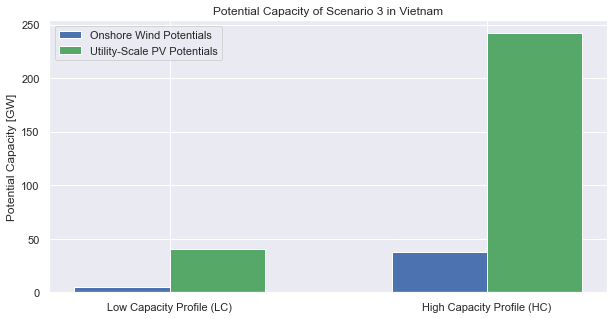

In [829]:
cap_arr = ['Low Capacity Profile (LC)', 'High Capacity Profile (HC)']
y_pos = np.arange(len(cap_arr))
wt_cap_arr = [wt_pc_lc, wt_pc_hc]
pv_cap_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt_rects = plt.bar(y_pos - 0.15, wt_cap_arr, width= 0.3,  color='b', label='Onshore Wind Potentials')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.3,  color='g', label='Utility-Scale PV Potentials')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('Potential Capacity of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_capacity_scenario3_method1.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

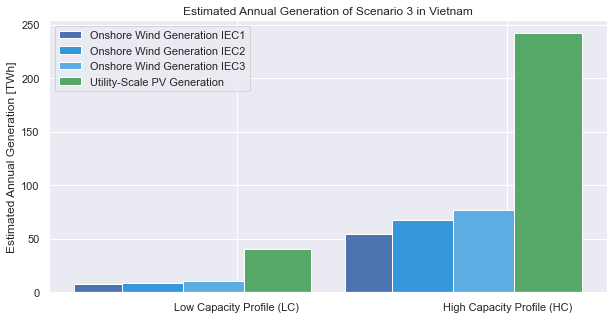

In [830]:
y_pos = np.arange(len(cap_arr))
# wind class IEC1-3 needs to be separated
wt_gen1_arr = [wt_ag_cf1_lc, wt_ag_cf1_hc]
wt_gen2_arr = [wt_ag_cf2_lc, wt_ag_cf2_hc]
wt_gen3_arr = [wt_ag_cf3_lc, wt_ag_cf3_hc]
pv_gen_arr = [pv_ag_lc, pv_ag_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
wt1_rects = plt.bar(y_pos - 0.45, wt_gen1_arr, width= 0.3,  color='b', label='Onshore Wind Generation IEC1')
wt2_rects = plt.bar(y_pos - 0.3, wt_gen2_arr, width= 0.25,  color='#3498DB', label='Onshore Wind Generation IEC2')
wt3_rects = plt.bar(y_pos - 0.05, wt_gen3_arr, width= 0.3,  color='#5DADE2', label='Onshore Wind Generation IEC3')
pv_rects = plt.bar(y_pos + 0.15, pv_cap_arr, width=0.25,  color='g', label='Utility-Scale PV Generation')
plt.xticks(y_pos, cap_arr)
plt.ylabel('Estimated Annual Generation [TWh]')
plt.title('Estimated Annual Generation of Scenario 3 in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_generation_scenario3_method1.tiff',bbox_inches='tight', dpi=300)
plt.legend()
plt.show()

## 4. Method 2: Calculate the potentials capacity & annual generation via real PV/turbine selection
(a) whole country<br>
(b) Regional division (under development) <br>


**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

In [28]:
# Check the data type of each column in current dataframe df
df.dtypes

latitude                                                     float64
longitude                                                    float64
time                                                  datetime64[ns]
year                                                           int64
month                                                          int64
day                                                            int64
hour                                                           int64
u-component_of_wind_speed_at_height_100m[m/s]                float32
v-component_of_wind_speed_at_height_100m[m/s]                float32
wind_speed_at_height_100m[m/s]                               float32
total_sky_direct_solar_radiation_at_surface[J/m2]            float32
total_sky_direct_solar_radiation_at_surface[Wh/m2]           float32
dtype: object

### a. Calculate the hourly data of wind and solar resources

Use average value of each hours to represent the overall hourly data across the country <br>
*The data will have 8784 rows (366 day or 8784 hours in 2020), and hence it might take 15-20 minutes to complete the calculation) <br>
*For normalisation of data, the data in February 29th will be removed in order to keep all years in 8760 hours

In [32]:
# Creating an empty Dataframe with column names only
new_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'average_wind_speed_at_height_100m[m/s]', 'average_sky_direct_solar_radiation_at_surface[Wh/m2]'])

# Using for loop to take mean value of all longtitudes and latitudes in each hour of the year
for i in range(1, 13): # months from January to December
    for j in range(1,32): # day from 1 to 31 
        for k in range (0,24): # hours from 0 to 23
            select_df = df.loc[(df['month'] == i) & (df['day'] == j) & (df['hour'] == k)] # locate the hours 
            avg_wind = select_df['wind_speed_at_height_100m[m/s]'].mean(axis = 0, skipna = True) # take mean wind speed value of the hour
            avg_solar = select_df['total_sky_direct_solar_radiation_at_surface[Wh/m2]'].mean(axis = 0, skipna = True) # take mean direct solar radiation of the hour
            # add the values into new Dataframe
            new_df = new_df.append({'time': select_df['time'],
                                    'year': 2020,
                                    'month': i, 
                                    'day': j, 
                                    'hour': k, 
                                    'average_wind_speed_at_height_100m[m/s]': avg_wind,
                                    'average_sky_direct_solar_radiation_at_surface[Wh/m2]': avg_solar}, ignore_index=True)
# remove the empty rows
new_df_drop = new_df.dropna()

# stanardize the year in 8760 hrs
copy_new_df = new_df_drop.copy()
feb_df = copy_new_df[((copy_new_df['month'] == 2) & (copy_new_df['day'] == 29))].index
copy_new_df.drop(feb_df, inplace = True)

# correct the value in time column from string into integer
copy_new_df['year'] = copy_new_df['year'].astype(np.int64)
copy_new_df['month'] = copy_new_df['month'].astype(np.int64)
copy_new_df['day'] = copy_new_df['day'].astype(np.int64)
copy_new_df['hour'] = copy_new_df['hour'].astype(np.int64)
copy_new_df

,time,year,month,day,hour,average_wind_speed_at_height_100m[m/s],average_sky_direct_solar_radiation_at_surface[Wh/m2]
0,0 2020-01-01 8784 2020-01-01 17...,2020,1,1,0,6.063948,7.086413
1,1 2020-01-01 01:00:00 8785 2020...,2020,1,1,1,6.001541,75.655800
2,2 2020-01-01 02:00:00 8786 2020...,2020,1,1,2,6.225554,194.520981
3,3 2020-01-01 03:00:00 8787 2020...,2020,1,1,3,6.448334,322.332581
4,4 2020-01-01 04:00:00 8788 2020...,2020,1,1,4,6.459966,400.505493
...,...,...,...,...,...,...,...
8923,8779 2020-12-31 19:00:00 17563 2020...,2020,12,31,19,7.531958,0.000000
8924,8780 2020-12-31 20:00:00 17564 2020...,2020,12,31,20,7.560935,0.000000
8925,8781 2020-12-31 21:00:00 17565 2020...,2020,12,31,21,7.599750,0.000000
8926,8782 2020-12-31 22:00:00 17566 2020...,2020,12,31,22,7.232974,0.000000


In [33]:
# convert time zone from UTC to UTC+7
utc_df = copy_new_df.copy()
utc_df['time'] = pd.to_datetime(utc_df[['year', 'month', 'day', 'hour']])
utc_df['time'] = pd.Series(utc_df['time'], dtype='datetime64[ns, Asia/Ho_Chi_Minh]')

# change year, month and day name
utc_df['year'] = pd.DatetimeIndex(utc_df['time']).year
utc_df['month'] = pd.DatetimeIndex(utc_df['time']).month
utc_df['day'] = pd.DatetimeIndex(utc_df['time']).day
utc_df['hour'] = pd.DatetimeIndex(utc_df['time']).hour

# add last six hours back to beginning and replace the time stamp
utc_df.iloc[-7:, 1] = 2020
utc_df['time'] = pd.to_datetime(utc_df[['year', 'month', 'day', 'hour']])

# sort by time
utc_df.sort_values(by=['time'], inplace = True)
utc_df.set_index(['time'],inplace=True)
utc_df = utc_df.iloc[: , 1:]
utc_df

,month,day,hour,average_wind_speed_at_height_100m[m/s],average_sky_direct_solar_radiation_at_surface[Wh/m2]
time,,,,,
2020-01-01 00:00:00,1,1,0,7.641319,0.0
2020-01-01 01:00:00,1,1,1,7.594773,0.0
2020-01-01 02:00:00,1,1,2,7.531958,0.0
2020-01-01 03:00:00,1,1,3,7.560935,0.0
2020-01-01 04:00:00,1,1,4,7.599750,0.0
...,...,...,...,...,...
2020-12-31 19:00:00,12,31,19,7.427829,0.0
2020-12-31 20:00:00,12,31,20,7.573410,0.0
2020-12-31 21:00:00,12,31,21,7.639140,0.0


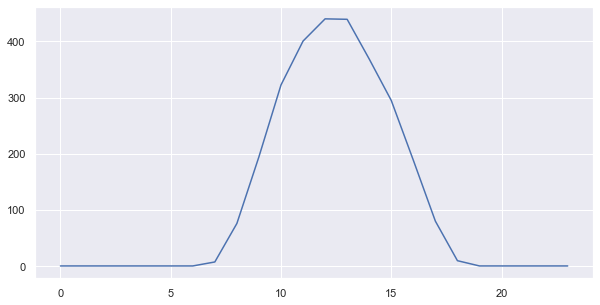

In [154]:
# recheck of the values with graph
sns.set(rc={'figure.figsize':(10,5)})
day_df = utc_df.loc[(utc_df['month'] == 1) & (utc_df['day'] == 1)]
plt.plot(day_df['hour'], day_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'])

In [514]:
# Save csv file
utc_wind_df = utc_df.drop(columns=['average_sky_direct_solar_radiation_at_surface[Wh/m2]'])
utc_solar_df = utc_df.drop(columns=['average_wind_speed_at_height_100m[m/s]'])
utc_wind_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_speed_100m_method2.csv', index = True)
utc_solar_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_solar_irradiation_method2.csv', index = True)

### b. Plot a annual hourly graphs of average total solar radiation and mean wind speed at height 100m

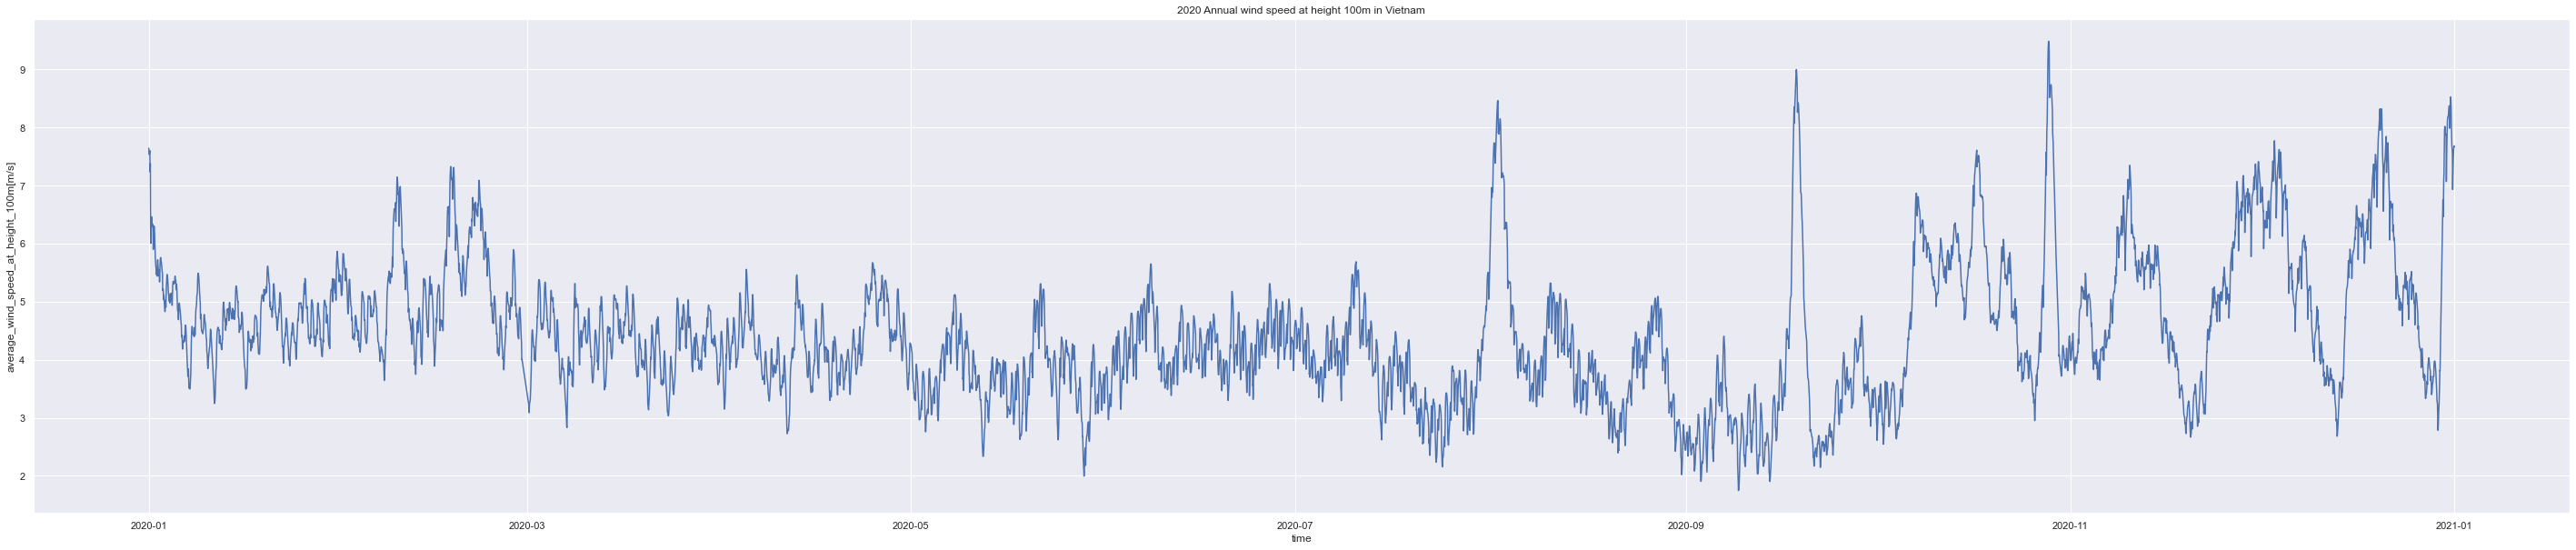

In [515]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="average_wind_speed_at_height_100m[m/s]", data=utc_wind_df)
plt.title('2020 Annual wind speed at height 100m in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_speed_method2.tiff', dpi=300)
plt.show()

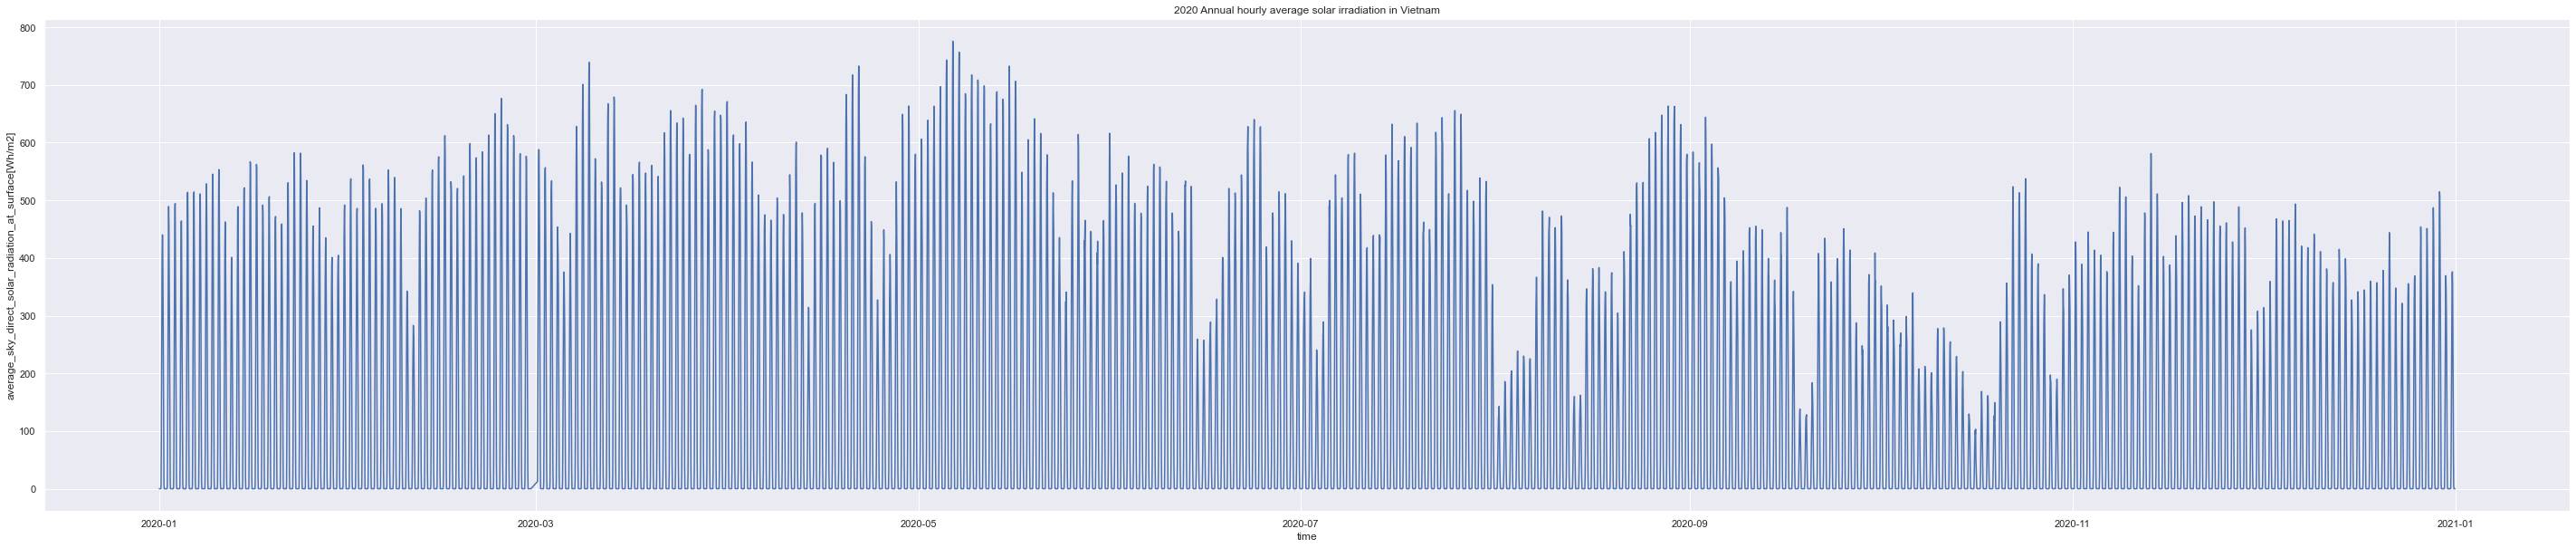

In [516]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="average_sky_direct_solar_radiation_at_surface[Wh/m2]", data=utc_solar_df)
plt.title('2020 Annual hourly average solar irradiation in Vietnam')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_solar_irradiation_method2.tiff', dpi=300)
plt.show()

### c. Calculate Wind potential capacity & annual generation 

Wind Turbine selection:
Gamesa G128-5.0MW (5 MW) <br>
Reference: https://en.wind-turbine-models.com/turbines/767-gamesa-g128-5.0mw <br>
Diameter: 128m <br>
Hub Height: 95m

In [128]:
# wind turbine assumption
# wind
# rated power 5MW
wt_p_2 = 5
# rotor diameter 128m
r_dia_2 = 0.128
# distance between wind turbine: L*W = (4*rotor diameter)*(4*rotor diameter) (km2)
wt_d_2 = 4*r_dia_2*4*r_dia_2

# turbine power curve Gamesa G128-5.0MW https://en.wind-turbine-models.com/turbines/767-gamesa-g128-5.0mw
pc_g128_mw = [0.059, 0.195, 0.420, 0.786, 1.296, 
            1.943, 2.699, 3.487, 4.174, 4.639, 
            4.875, 4.965, 5.000, 5.000, 4.984,
            4.944, 4.859, 4.722, 4.541, 4.331,
            4.108, 3.883, 3.661, 3.447, 3.247]

In [81]:
# define function of wind power curve conversion (variables: cut-in speed, cut-off speed, hourly wind speed dataframe, wind turbine power curve, number of turbines)
def wind_p_curve(cut_in,cut_off, power_df,pc_value_mw, wt_amount):
    # excluding cut-in and cut-off speeds
    for i in range(8760):
        if (power_df.iat[i,3] <cut_in) or (power_df.iat[i,3] >cut_off):
            power_df.iat[i,3] = 0

    # covert wind speed into power generation according to power curve
    level = len(pc_value_mw)
    for speed in range(level):
        for i in range(8760):
            if power_df.iat[i,3] >= (speed+3) and power_df.iat[i,3] <(speed+4):
                power_df.iat[i,3] = pc_value_mw[speed]
           
    power_df.rename(columns={'average_wind_speed_at_height_100m[m/s]': 'hourly_wind_generation[TWh]'}, inplace = True)
    power_df['hourly_wind_generation[TWh]'] = power_df['hourly_wind_generation[TWh]']*wt_amount/10**6 
    return power_df

In [129]:
# wind turbine calculation
# total amount of wind turbines that can be installed on available land
wd_amount = land_sum*wt_sh / wt_d_2

wind_2_df = utc_wind_df.copy()
# run power curve function to execute generation
# function of wind power curve conversion (variables: cut-in speed, cut-off speed, hourly wind speed dataframe, wind turbine power curve, number of turbines)
wind_p_curve(3,20, wind_2_df, pc_g128_mw, wd_amount)


# total install capacity of all wind turbines (GW)
wd_2_cp = wd_amount*wt_p_2/10**3

# annual total geneartion of all wind turbines (TWh)
wd_2_sum = wind_2_df['hourly_wind_generation[TWh]'].sum(axis = 0, skipna = True)

# capacity factor
wd_2_cf = wd_2_sum*10**3/(wd_2_cp*8760)

print('Method 2 Real Wind Turbine Selection',
      '\nOnshore windfarm potential capacity of scenario 3 in', name, ':', wd_2_cp, 'GW',
      '\nOnshore windfarm estimated annual generation of scenario 3 in Vietnam in', name, ':', wd_2_sum, 'TWh',
      '\nOnshore windfarm capacity factor of scenario 3 in', name, ':', wd_2_cf)

Method 2 Real Wind Turbine Selection 
Onshore windfarm potential capacity of scenario 3 in Vietnam : 15.371155461474329 GW 
Onshore windfarm estimated annual generation of scenario 3 in Vietnam in Vietnam : 7.085069726092655 TWh 
Onshore windfarm capacity factor of scenario 3 in Vietnam : 0.052617899543379004


In [517]:
# Save csv file
wind_2_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_5mw_method2.csv', index = True)

### d. Calculate Solar PV potential capacity & annual generation (ignoring tilt angle)

PV Panel selection:
LG MONO X PLUS 450W SOLAR PANEL LG450U6 (450W) <br>
Reference: https://www.zerohomebills.com/product/lg-mono-x-plus-450w-solar-panel/ <br>
Rated Power: 450 W Solar Panel<br>
Efficiency: 20.2 % <br>
Size: 2115 x 1052 x 40 mm<br>

In [138]:
# PV assumption
# dimension: 1960x1380x40 mm
dim_2 = 2115*1052
# rated power 450Wp
pv_p_2 = 450
# efficiency factor of the PV modules: 20.2 (%)
pv_ef_2 = 0.202

In [146]:
# PV calculation
# total amount of pv that can be installed on available land
pv_amount = land_sum*pv_sh / (dim_2/10**12)


# total install capacity of all pv (GW)
pv_2_cp = pv_amount*pv_p_2/10**9


pv_2_df = utc_solar_df.copy()

# convert irradiation into generation (Wh)
pv_2_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'] = pv_2_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]']*pv_ef_2
# define maximum hourly geneartion 
pv_2_df.loc[pv_2_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'] >pv_p_2] = pv_p_2
# convert from Wh to TWh
pv_2_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]'] = (pv_2_df['average_sky_direct_solar_radiation_at_surface[Wh/m2]']*land_sum*pv_sh*10**6)/10**12
pv_2_gen_df = pv_2_df.rename(columns={'average_sky_direct_solar_radiation_at_surface[Wh/m2]': 'annual_pv_generation[TWh]'})
# annual solar generation 
pv_2_sum = pv_2_gen_df['annual_pv_generation[TWh]'].sum(axis = 0, skipna = True)


# capacity factor = annual generation (TWh) / capacity (TWh) * 8760hr
pv_2_cf = pv_2_sum*10**3/(pv_2_cp*8760)

print('Method 2 Real PV Selection',
      '\nUtility-Scale PV potential capacity of scenario 3 in', name, ':', pv_2_cp, 'GW',
      '\nUtility-Scale PV estimated annual generation of scenario 3 in', name, ':', pv_2_sum, 'TWh',
      '\nUtility-Scale PV capacity factor of scenario 3  in', name, ':',  pv_2_cf)

Method 2 Real PV Selection 
Utility-Scale PV potential capacity of scenario 3 in Vietnam : 162.99070371704258 GW 
Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 189.73528928433024 TWh 
Utility-Scale PV capacity factor of scenario 3  in Vietnam : 0.13288659478560866


In [518]:
# Save csv file of annual total solar geneartion of all pv
pv_2_gen_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_450w_method2.csv', index = True)

### e. Calculate and plot annual hourly generation 

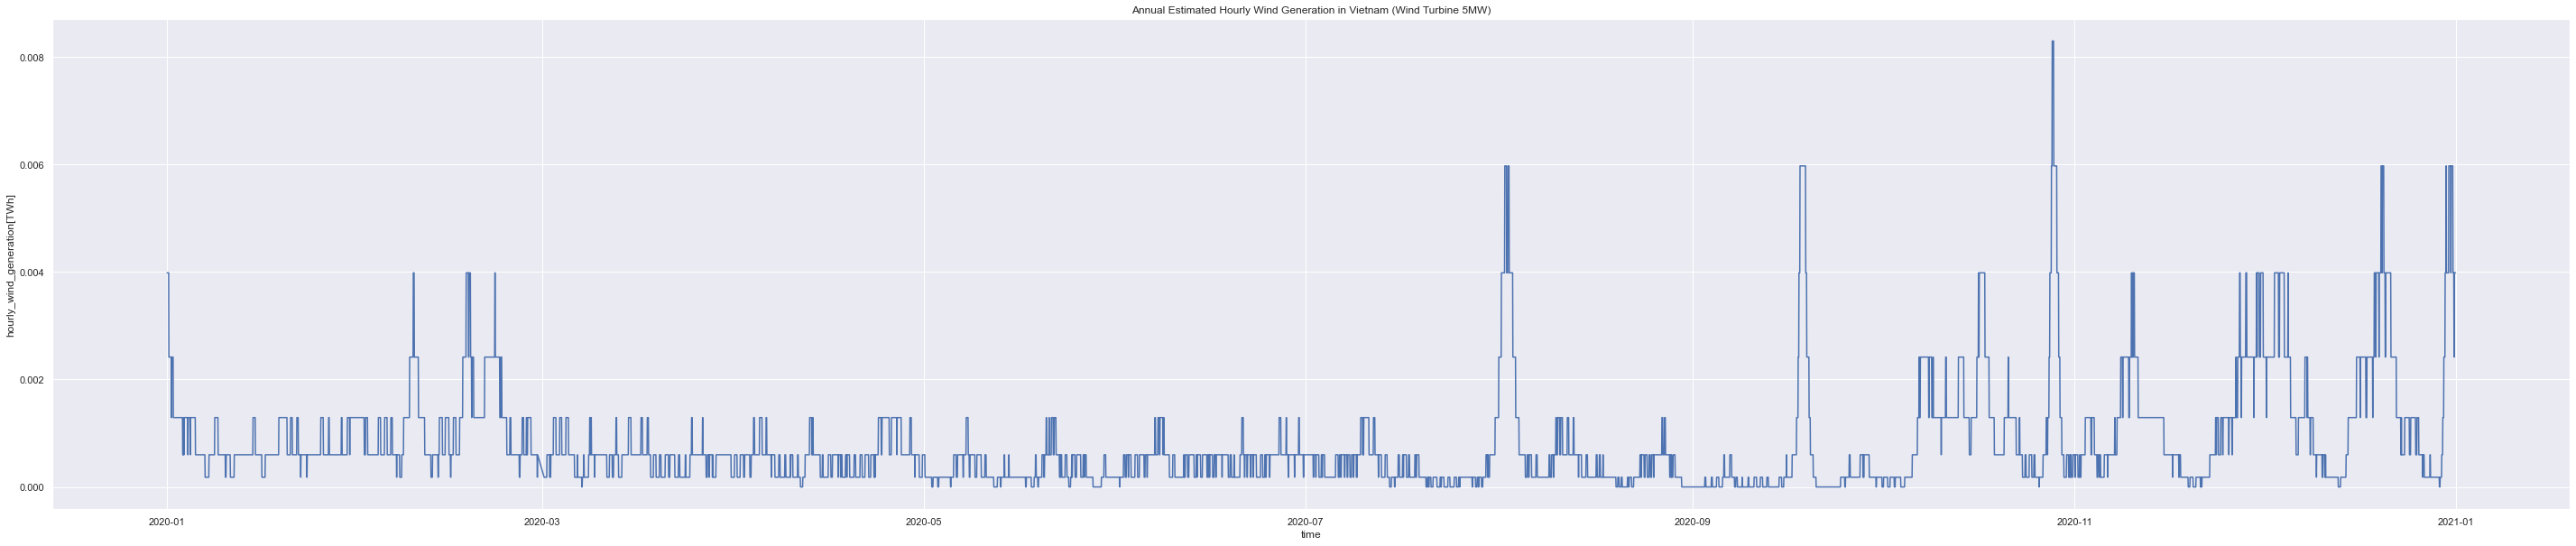

In [519]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="hourly_wind_generation[TWh]", data=wind_2_df)
plt.title('Annual Estimated Hourly Wind Generation in Vietnam (Wind Turbine 5MW)')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_5mw_method2.tiff', dpi=300)
plt.show()

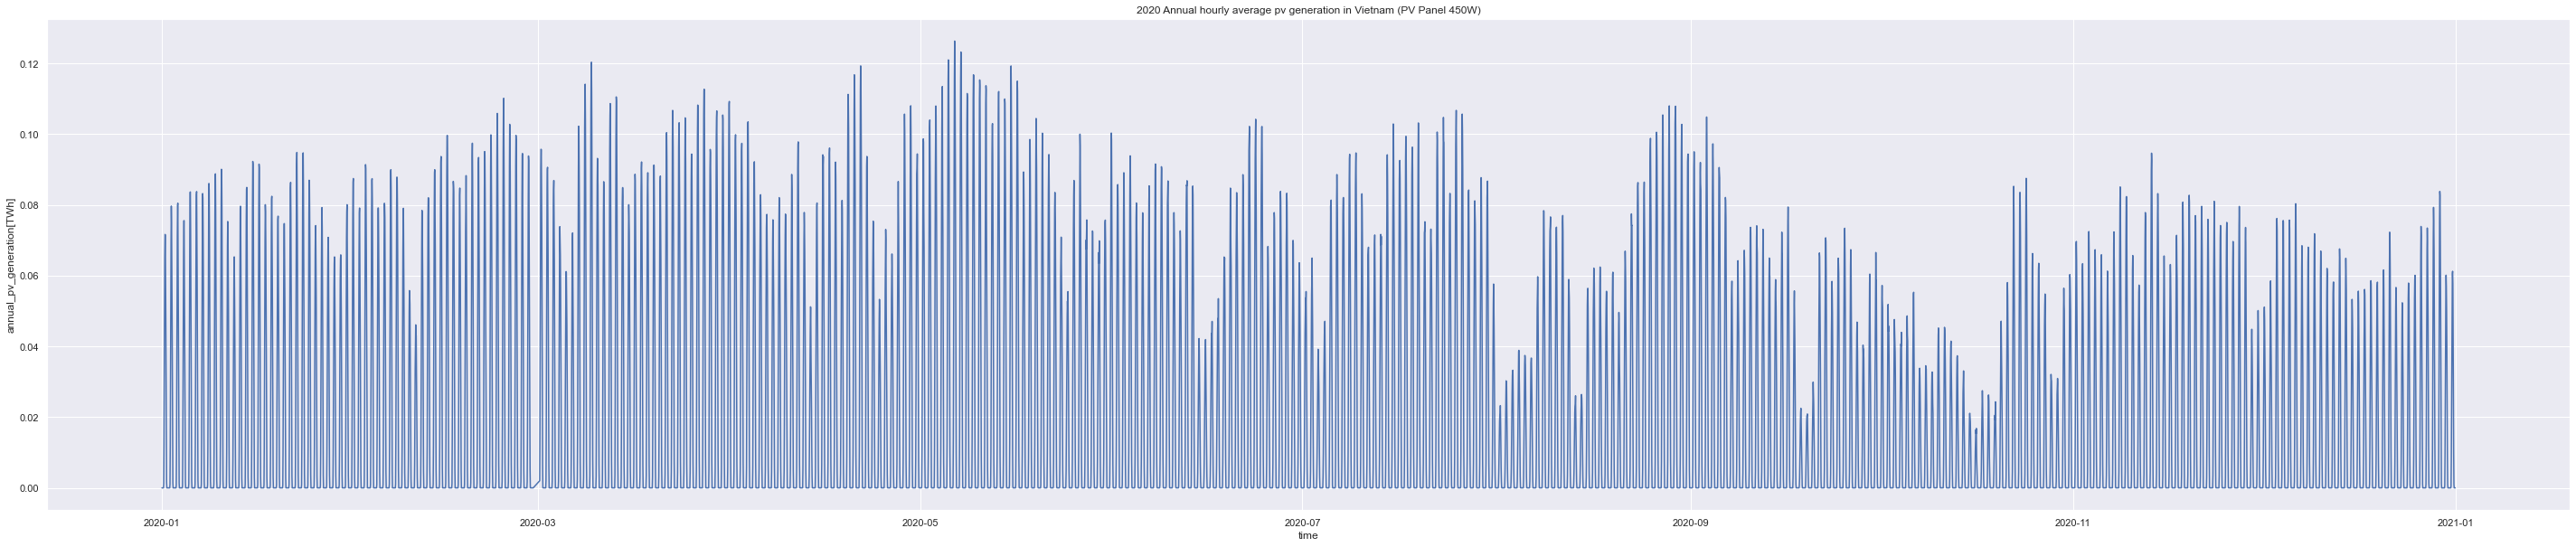

In [520]:
sns.set(rc={'figure.figsize':(50,10)})
sns.lineplot(x="time", y="annual_pv_generation[TWh]", data=pv_2_gen_df)
plt.title('2020 Annual hourly average pv generation in Vietnam (PV Panel 450W)')
plt.savefig(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_450w_method2.tiff', dpi=300)
plt.show()

## 5. Method 3: Calculate the potentials capacity & annual generation via average hourly generation from 4 different cities
(a) whole country<br>
(b) Regional division (under development) <br>
*hourly generation of one onshore wind turbine and one pv panel are used from 4 different cities in Vietnam (Hanoi, Vinh, Da Nang, and Ho Chi Minh)<br>
**The analysis divides the available land areas (scenario 3 from stage 2) into 50% for utility solar PV and 50% for onshore wind farm planning.**

### a. Calculate the hourly data of wind and solar resources

In [728]:
# define function of time sorting (variables: input_df)
def time_sort(input_df):
    # reset time column into date time and select it as new index
    input_df.set_index('local_time')
    # add year, month and day name
    input_df['year'] = 2020
    input_df['month'] = pd.DatetimeIndex(input_df['local_time']).month
    input_df['day'] = pd.DatetimeIndex(input_df['local_time']).day
    input_df['hour'] = pd.DatetimeIndex(input_df['local_time']).hour
    # add last six hours back to beginning and replace the time stamp
    input_df['local_time'] = pd.to_datetime(input_df[['year', 'month', 'day', 'hour']])
    # sort by time
    input_df.sort_values(by=['local_time'], inplace = True)
    return input_df

In [729]:
# define function of aonnual conversion (variables: empty_df, input_df, capacity)
def method3_gen(empty_df, input_df, capacity):
    empty_df = pd.DataFrame(columns=['time','year', 'month', 'day', 'hour', 'hourly_generation[kWh]'])
    # Using for loop to take mean value of all longtitudes and latitudes in each hour of the year
    for i in range(1, 13): # months from January to December
        for j in range(1,32): # day from 1 to 31 
            for k in range (0,24): # hours from 0 to 23
                select_df = input_df.loc[(input_df['month'] == i) & (input_df['day'] == j) & (input_df['hour'] == k) & (input_df['capacity'] == capacity)] # locate the hours 
                avg_time = select_df['local_time'].mean(axis = 0, skipna = True) # take mean value of the hour
                avg_gen = select_df['electricity'].mean(axis = 0, skipna = True) # take mean value of the hour
                # add the values into new Dataframe
                empty_df = empty_df.append({'time': avg_time,
                                            'year': 2020,
                                            'month': i,
                                            'day': j,
                                            'hour': k,
                                            'hourly_generation[kWh]': avg_gen}, ignore_index=True)
    # correct the value in time column from string into integer
    empty_df['year'] = empty_df['year'].astype(np.int64)
    empty_df['month'] = empty_df['month'].astype(np.int64)
    empty_df['day'] = empty_df['day'].astype(np.int64)
    empty_df['hour'] = empty_df['hour'].astype(np.int64)
    return empty_df

In [730]:
# this is the profile of singel wind turbine and singel pv panel module in 4 cities
m3_wt_sort_df = wt_fileOne_df.copy()
m3_pv_sort_df = pv_fileOne_df.copy()
# execute the time sorting function
%time time_sort(m3_wt_sort_df)
%time time_sort(m3_pv_sort_df)

Wall time: 18.2 s
Wall time: 18 s


,local_time,electricity,city,latitude,longtitude,type,capacity,year,month,day,hour
8753,2020-01-01 00:00:00,0.0,DaNang,16.0680,108.2120,PHOT,250.0,2020,1,1,0
8753,2020-01-01 00:00:00,0.0,Vinh,18.6692,105.6882,PHOT,250.0,2020,1,1,0
8753,2020-01-01 00:00:00,0.0,DaNang,16.0680,108.2120,PHOT,600.0,2020,1,1,0
8753,2020-01-01 00:00:00,0.0,HoChiMinh,10.7758,106.7018,PHOT,250.0,2020,1,1,0
8753,2020-01-01 00:00:00,0.0,Hanoi,21.0294,105.8544,PHOT,600.0,2020,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
8752,2020-12-31 23:00:00,0.0,DaNang,16.0680,108.2120,PHOT,600.0,2020,12,31,23
8752,2020-12-31 23:00:00,0.0,Hanoi,21.0294,105.8544,PHOT,600.0,2020,12,31,23
8752,2020-12-31 23:00:00,0.0,Vinh,18.6692,105.6882,PHOT,250.0,2020,12,31,23
8752,2020-12-31 23:00:00,0.0,Hanoi,21.0294,105.8544,PHOT,250.0,2020,12,31,23


In [731]:
# this is the profile of singel wind turbine and singel pv panel module in 4 cities
# execute the annual generation function
%time wt_75mw_df = method3_gen(wt_75mw_df, m3_wt_sort_df, 7.5)
%time wt_2mw_df = method3_gen(wt_2mw_df, m3_wt_sort_df, 2)
%time pv_600w_df = method3_gen(pv_600w_df, m3_pv_sort_df, 600)
%time pv_250w_df = method3_gen(pv_250w_df, m3_pv_sort_df, 250)

Wall time: 52.1 s
Wall time: 54 s
Wall time: 54.1 s
Wall time: 1min 43s


In [739]:
# this is the profile of singel wind turbine and singel pv panel module in 4 cities
# remove empty rows
wt_75mw_drop_df = wt_75mw_df.dropna()
wt_2mw_drop_df = wt_2mw_df.dropna()
pv_600w_drop_df = pv_600w_df.dropna()
pv_250w_drop_df = pv_250w_df.dropna()
# correct name of generation column
wt_75mw_new_df = wt_75mw_drop_df.copy()
wt_2mw_new_df = wt_2mw_drop_df.copy()
pv_600w_new_df = pv_600w_drop_df.copy()
pv_250w_new_df = pv_250w_drop_df.copy()

# convert unit from MW/w to TWh
wt_75mw_new_df['hourly_generation[kWh]'] = (wt_75mw_new_df['hourly_generation[kWh]'])/10**9
wt_2mw_new_df['hourly_generation[kWh]'] = (wt_2mw_new_df['hourly_generation[kWh]'])/10**9
pv_600w_new_df['hourly_generation[kWh]'] = (pv_600w_drop_df['hourly_generation[kWh]'])/10**9
pv_250w_new_df['hourly_generation[kWh]'] = (pv_250w_drop_df['hourly_generation[kWh]'])/10**9

wt_75mw_new_df.rename(columns={'hourly_generation[kWh]': "hourly_wind_generation[TWh]"}, inplace = True)
wt_2mw_new_df.rename(columns={'hourly_generation[kWh]': "hourly_wind_generation[TWh]" }, inplace = True)
pv_600w_new_df.rename(columns={'hourly_generation[kWh]': "hourly_pv_generation[TWh]" }, inplace = True)
pv_250w_new_df.rename(columns={'hourly_generation[kWh]': "hourly_pv_generation[TWh]" }, inplace = True)
wt_75mw_new_df

,time,year,month,day,hour,hourly_wind_generation[TWh]
0,2020-01-01 00:00:00,2020,1,1,0,0.000001
1,2020-01-01 01:00:00,2020,1,1,1,0.000001
2,2020-01-01 02:00:00,2020,1,1,2,0.000001
3,2020-01-01 03:00:00,2020,1,1,3,0.000001
4,2020-01-01 04:00:00,2020,1,1,4,0.000001
...,...,...,...,...,...,...
8923,2020-12-31 19:00:00,2020,12,31,19,0.000001
8924,2020-12-31 20:00:00,2020,12,31,20,0.000001
8925,2020-12-31 21:00:00,2020,12,31,21,0.000001
8926,2020-12-31 22:00:00,2020,12,31,22,0.000001


### b. Calculate Wind potential capacity and annual generation

Wind Turbine selection: <br>
1. Enercon E-126 7500 (7.5 MW) <br>
Reference: https://www.enercon.de/en/products/ep-8/e-126/ <br>
Diameter: 127m <br>
Hub Height: 100m <br>
2. Vestas V90 2MW (2 MW) <br>
Reference: https://en.wind-turbine-models.com/turbines/16-vestas-v90 <br>
Diameter: 90m <br>
Hub Height: 105m <br>

In [740]:
# wind turbine assumption
# wind
# rated power 7.5MW , 2MW
wt_p75_3 = 7.5
wt_p2_3 = 2
# rotor diameter 127m, 105m
r_dia75_3 = 0.127
r_dia2_3 = 0.105
# distance between wind turbine: L*W = (4*rotor diameter)*(4*rotor diameter) (km2)
wt_d75_3 = 4*r_dia75_3*4*r_dia75_3
wt_d2_3 = 4*r_dia2_3*4*r_dia2_3
# total amount of wind turbines that can be installed on available land
wd_amount75_3 = land_sum*wt_sh / wt_d75_3
wd_amount2_3 = land_sum*wt_sh / wt_d2_3

In [741]:
# convert wind turbine df from single turbine to total turbines
wt_75mw_new_df['hourly_wind_generation[TWh]'] = (wt_75mw_new_df['hourly_wind_generation[TWh]'])*wd_amount75_3
wt_2mw_new_df['hourly_wind_generation[TWh]'] = (wt_2mw_new_df['hourly_wind_generation[TWh]'])*wd_amount2_3
wt_75mw_new_df.head()

,time,year,month,day,hour,hourly_wind_generation[TWh]
0,2020-01-01 00:00:00,2020,1,1,0,0.004017
1,2020-01-01 01:00:00,2020,1,1,1,0.003742
2,2020-01-01 02:00:00,2020,1,1,2,0.003605
3,2020-01-01 03:00:00,2020,1,1,3,0.003552
4,2020-01-01 04:00:00,2020,1,1,4,0.003513


In [753]:
# wind turbine calculation

# total install capacity of all wind turbines (GW)
wd_3_cp75 = wd_amount75_3*wt_p75_3/10**3
wd_3_cp2 = wd_amount2_3*wt_p2_3/10**3

# annual total geneartion of all wind turbines (TWh)
wd_3_sum75 = wt_75mw_new_df['hourly_wind_generation[TWh]'].sum(axis = 0, skipna = True)
wd_3_sum2 = wt_2mw_new_df['hourly_wind_generation[TWh]'].sum(axis = 0, skipna = True)

# capacity factor
wd_3_cf75 = wd_3_sum75*10**3/(wd_3_cp75*8760)
wd_3_cf2 = wd_3_sum2*10**3/(wd_3_cp2*8760)
    
print('Method 3 Estimated Hourly Generation',
      '\nOnshore windfarm potential capacity of scenario 3 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_3_cp75, 'GW',
      '\n (2) Wind Turbine 2 MW', wd_3_cp2, 'GW',
      '\nOnshore windfarm estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_3_sum75, 'TWh',
      '\n (2) Wind Turbine 2 MW', wd_3_sum2, 'TWh',
      '\nOnshore windfarm capacity factor of scenario 3 in', name, ':', 
      '\n (1) Wind Turbine 7.5 MW', wd_3_cf75,
      '\n (2) Wind Turbine 2 MW', wd_3_cf2)

Method 3 Estimated Hourly Generation 
Onshore windfarm potential capacity of scenario 3 in Vietnam : 
 (1) Wind Turbine 7.5 MW 23.42126087303572 GW 
 (2) Wind Turbine 2 MW 9.137088837398474 GW 
Onshore windfarm estimated annual generation of scenario 3 in Vietnam : 
 (1) Wind Turbine 7.5 MW 22.119712376448977 TWh 
 (2) Wind Turbine 2 MW 14.409253484500296 TWh 
Onshore windfarm capacity factor of scenario 3 in Vietnam : 
 (1) Wind Turbine 7.5 MW 0.1078115023439878 
 (2) Wind Turbine 2 MW 0.1800236354880137


In [755]:
# Save csv file of annual total wind geneartion
wt_75mw_new_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_75mw_method3.csv', index = True)
wt_2mw_new_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_wind_generation_wind_turbine_2mw_method3.csv', index = True)

### c. Calculate Solar PV potential capacity & annual generation (tilt angle 35 degree)

PV Panel selection:
1. Canadian SolarHiKu7 (600W) <br>
Reference: https://testsolar.csisolar.com/wp-content/uploads/2020/10/Canadian_Solar-Flyer-HiKu7_CS7L-MS_EN.pdf <br>
Rated Power: 600 W Solar Panel<br>
Efficiency: 21.2 % <br>
Size: 2172 x 1303 x 35 mm<br>
2. Centsys 250W (250W) <br>
Reference: https://www.centsys.com.au/pdf/Solar/0.07.B.0133%20250W%20Solar%20Panel%20Specifications%20sheet-29062015-NG.pdf <br>
Rated Power: 250 W Solar Panel<br>
Efficiency: 17.2 % <br>
Size: 1650 x 992 x 40 mm<br>

In [745]:
# PV assumption
# dimension: 2172x1303x35 mm/ 1650x992x40mm
dim_p6_3 = 2172*1303
dim_p25_3 = 1650*992
# rated power 600Wp / 250Wp
pv_p6_3 = 600
pv_p25_3 = 250
# efficiency factor of the PV modules: 21.2 (%) / 17.2 (%)
pv_ef6_3 = 0.212
pv_ef25_3 = 0.172
# total amount of pv that can be installed on available land
pv_amount6_3 = land_sum*pv_sh / (dim_p6_3/10**12)
pv_amount25_3 = land_sum*pv_sh / (dim_p25_3/10**12)

In [746]:
# convert pv panel df from single panel to total panels
pv_600w_new_df['hourly_pv_generation[TWh]'] = (pv_600w_new_df['hourly_pv_generation[TWh]'])*pv_amount6_3
pv_250w_new_df['hourly_pv_generation[TWh]'] = (pv_250w_new_df['hourly_pv_generation[TWh]'])*pv_amount25_3
pv_250w_new_df.head()

,time,year,month,day,hour,hourly_pv_generation[TWh]
0,2020-01-01 00:00:00,2020,1,1,0,0.0
1,2020-01-01 01:00:00,2020,1,1,1,0.0
2,2020-01-01 02:00:00,2020,1,1,2,0.0
3,2020-01-01 03:00:00,2020,1,1,3,0.0
4,2020-01-01 04:00:00,2020,1,1,4,0.0


In [762]:
# PV calculation

# total install capacity of all pv (GW)
pv_3_cp6 = pv_amount*pv_p6_3/10**9
pv_3_cp25 = pv_amount*pv_p25_3/10**9

# annual solar generation 
pv_3_sum6 = pv_600w_new_df['hourly_pv_generation[TWh]'].sum(axis = 0, skipna = True)
pv_3_sum25 = pv_250w_new_df['hourly_pv_generation[TWh]'].sum(axis = 0, skipna = True)

# capacity factor = annual generation (TWh) / capacity (TWh) * 8760hr
pv_3_cf6 = pv_3_sum6*10**3/(pv_3_cp6*8760)
pv_3_cf25 = pv_3_sum25*10**3/(pv_3_cp25*8760)

print('Method 3 Estimated Hourly Generation',
      '\nUtility-Scale PV potential capacity of scenario 3 in', name, ':', 
      '\n (1) PV 600W:', pv_3_cp6, 'GW',
      '\n (2) PV 250W:', pv_3_cp25, 'GW',
      '\nUtility-Scale PV estimated annual generation of scenario 3 in', name, ':', 
      '\n (1) PV 600W:', pv_3_sum6, 'TWh',
      '\n (2) PV 250W:', pv_3_sum25, 'TWh',
      '\nUtility-Scale PV capacity factor of scenario 3 in', name, ':', 
      '\n (1) PV 600W:', pv_3_cf6,
      '\n (2) PV 250W:', pv_3_cf25)

Method 3 Estimated Hourly Generation 
Utility-Scale PV potential capacity of scenario 3 in Vietnam : 
 (1) PV 600W: 217.3209382893901 GW 
 (2) PV 250W: 90.55039095391254 GW 
Utility-Scale PV estimated annual generation of scenario 3 in Vietnam : 
 (1) PV 600W: 232.87693221397186 TWh 
 (2) PV 250W: 167.77867257420445 TWh 
Utility-Scale PV capacity factor of scenario 3 in Vietnam : 
 (1) PV 600W: 0.12232656867402329 
 (2) PV 250W: 0.21151555837735514


In [756]:
# Save csv file of annual total solar geneartion
pv_600w_new_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_600w_method3.csv', index = True)
pv_250w_new_df.to_csv(r'Vietnam/03_output_stage3/03_vn_annual_hourly_pv_generation_pv_panel_250w_method3.csv', index = True)

## 6. Comparison of different methods

### a. Utility PV

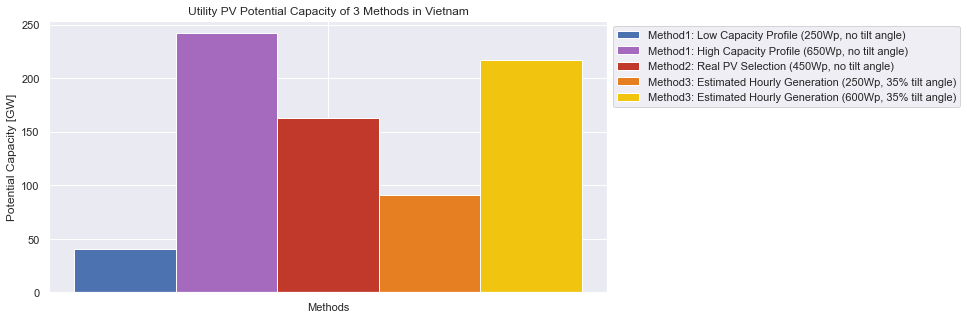

In [851]:
# Potential Capacity
method_arr = ['Methods']
y_pos = np.arange(1)
#method1_arr = [pv_pc_lc, wt_pc_hc]
#method2_arr = [pv_pc_lc, pv_pc_hc]
#method3_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_pc_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_pc_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv_rects = plt.bar(y_pos, pv_2_cp, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (450Wp, no tilt angle)')
m3_pv25_rects = plt.bar(y_pos + 0.2, pv_3_cp25, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m3_pv6_rects = plt.bar(y_pos + 0.4, pv_3_cp6, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('Utility PV Potential Capacity of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_potential_capacity_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

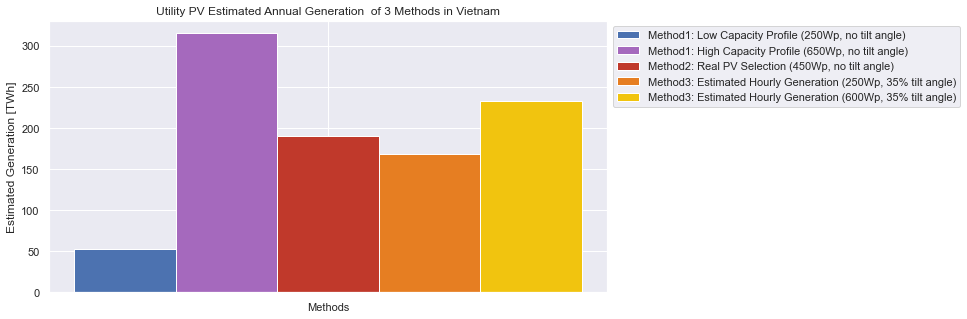

In [853]:
# Annual Generation
method_arr = ['Methods']
y_pos = np.arange(1)
#method1_arr = [pv_pc_lc, wt_pc_hc]
#method2_arr = [pv_pc_lc, pv_pc_hc]
#method3_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_ag_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_ag_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv_rects = plt.bar(y_pos, pv_2_sum, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (450Wp, no tilt angle)')
m3_pv25_rects = plt.bar(y_pos + 0.2, pv_3_sum25, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m3_pv6_rects = plt.bar(y_pos + 0.4, pv_3_sum6, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Estimated Generation [TWh]')
plt.title('Utility PV Estimated Annual Generation  of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_annual_generation_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

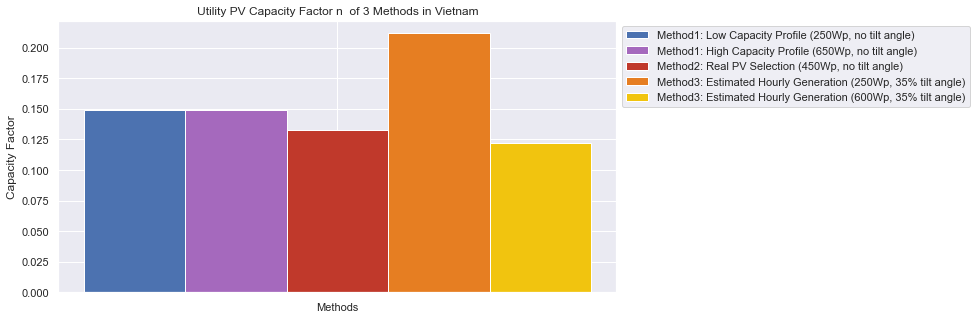

In [855]:
# Capacity Factor
method_arr = ['Methods']
y_pos = np.arange(1)
#method1_arr = [pv_pc_lc, wt_pc_hc]
#method2_arr = [pv_pc_lc, pv_pc_hc]
#method3_arr = [pv_pc_lc, pv_pc_hc]
bar_width = 0.35

sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, pv_ag_lc_cf, width= 0.2,  color='b', label='Method1: Low Capacity Profile (250Wp, no tilt angle)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, pv_ag_hc_cf, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (650Wp, no tilt angle)')
m2_pv_rects = plt.bar(y_pos, pv_2_cf, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (450Wp, no tilt angle)')
m3_pv25_rects = plt.bar(y_pos + 0.2, pv_3_cf25, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (250Wp, 35% tilt angle)')
m3_pv6_rects = plt.bar(y_pos + 0.4, pv_3_cf6, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (600Wp, 35% tilt angle)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Capacity Factor')
plt.title('Utility PV Capacity Factor n  of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_pv_capacity_factor_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

### b. OnShore Wind Turbine

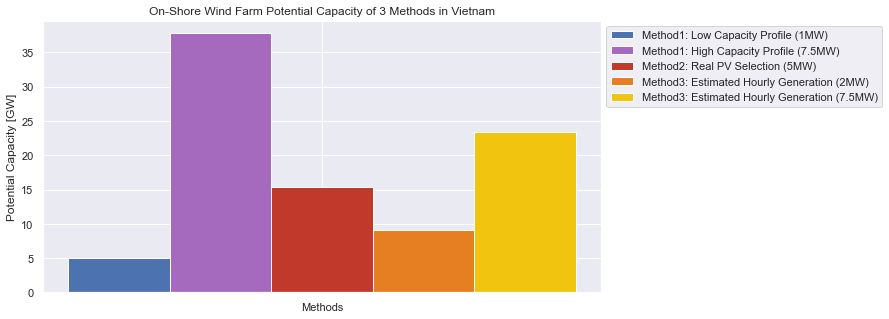

In [857]:
# Potential Capacity
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.4, wt_pc_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (1MW)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, wt_pc_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (7.5MW)')
m2_pv_rects = plt.bar(y_pos, wd_2_cp, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (5MW)')
m3_pv25_rects = plt.bar(y_pos + 0.2, wd_3_cp2, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (2MW)')
m3_pv6_rects = plt.bar(y_pos + 0.4, wd_3_cp75, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Potential Capacity [GW]')
plt.title('On-Shore Wind Farm Potential Capacity of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_potential_capacity_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

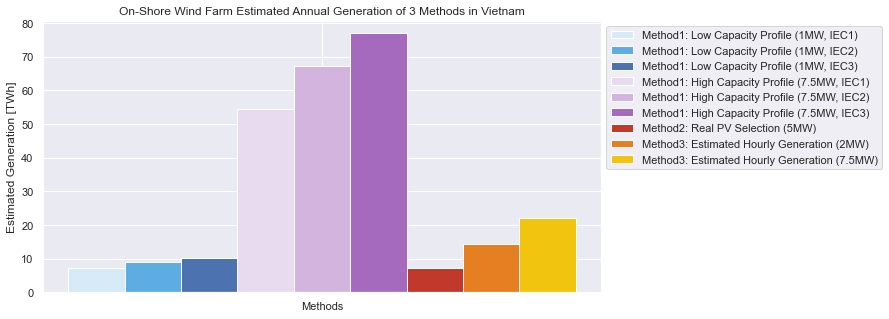

In [863]:
# Annual Generation
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.8, wt_ag_cf1_lc, width= 0.2,  color='#D6EAF8', label='Method1: Low Capacity Profile (1MW, IEC1)')
m1_pvlc_rects = plt.bar(y_pos - 0.6, wt_ag_cf2_lc, width= 0.2,  color='#5DADE2', label='Method1: Low Capacity Profile (1MW, IEC2)')
m1_pvlc_rects = plt.bar(y_pos - 0.4, wt_ag_cf3_lc, width= 0.2,  color='b', label='Method1: Low Capacity Profile (1MW, IEC3)')
m1_pvhc_rects = plt.bar(y_pos - 0.2, wt_ag_cf1_hc, width=0.2,  color='#E8DAEF', label='Method1: High Capacity Profile (7.5MW, IEC1)')
m1_pvhc_rects = plt.bar(y_pos, wt_ag_cf2_hc, width=0.2,  color='#D2B4DE', label='Method1: High Capacity Profile (7.5MW, IEC2)')
m1_pvhc_rects = plt.bar(y_pos + 0.2, wt_ag_cf3_hc, width=0.2,  color='#A569BD', label='Method1: High Capacity Profile (7.5MW, IEC3)')
m2_pv_rects = plt.bar(y_pos + 0.4, wd_2_sum, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (5MW)')
m3_pv25_rects = plt.bar(y_pos + 0.6, wd_3_sum2, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (2MW)')
m3_pv6_rects = plt.bar(y_pos + 0.8, wd_3_sum75, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Estimated Generation [TWh]')
plt.title('On-Shore Wind Farm Estimated Annual Generation of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_annual_generation_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

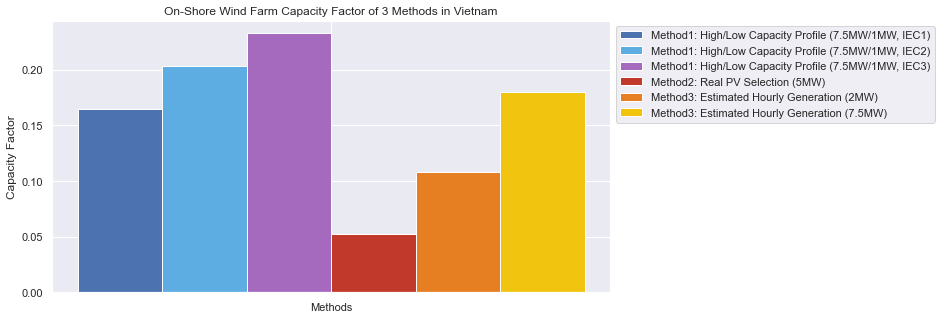

In [867]:
# Capacity Factor
sns.set(rc={'figure.figsize':(10,5)})
m1_pvlc_rects = plt.bar(y_pos - 0.5, wt_cf1_sum, width= 0.2,  color='b', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC1)')
m1_pvlc_rects = plt.bar(y_pos - 0.3, wt_cf2_sum, width= 0.2,  color='#5DADE2', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC2)')
m1_pvhc_rects = plt.bar(y_pos - 0.1, wt_cf3_sum, width=0.2,  color='#A569BD', label='Method1: High/Low Capacity Profile (7.5MW/1MW, IEC3)')
m2_pv_rects = plt.bar(y_pos + 0.1, wd_2_cf, width= 0.2,  color='#C0392B', label='Method2: Real PV Selection (5MW)')
m3_pv25_rects = plt.bar(y_pos + 0.3, wd_3_cf75, width=0.2,  color='#E67E22', label='Method3: Estimated Hourly Generation (2MW)')
m3_pv6_rects = plt.bar(y_pos + 0.5, wd_3_cf2, width=0.2,  color='#F1C40F', label='Method3: Estimated Hourly Generation (7.5MW)')
plt.xticks(y_pos, method_arr)
plt.ylabel('Capacity Factor')
plt.title('On-Shore Wind Farm Capacity Factor of 3 Methods in Vietnam')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.savefig(r'Vietnam/03_output_stage3/03_wind_capacity_factor_comparison.tiff',bbox_inches='tight', dpi=300)
plt.show()

*The results of wind turbine fits the capacity profile yet since the annual mean speed is at 4.4m/s and initial setup of hub height is at 100m, the capacity factor and generation of wind turbines will be relatively low due to oversizing of wind turbines. Compared to the ideal situation evaluated by mean power density, the values can be improved by selection of wind turbines.